#遷移學習(binary改categorical)計算confusion matrix

#InceptionV3


### Import必要套件

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/上課/TFkeras/catdog.zip /content

In [4]:
!unzip /content/catdog.zip -d /content/

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/catdog/train/dog/dog.5499.jpg  
  inflating: /content/catdog/train/dog/dog.55.jpg  
  inflating: /content/catdog/train/dog/dog.550.jpg  
  inflating: /content/catdog/train/dog/dog.5500.jpg  
  inflating: /content/catdog/train/dog/dog.5501.jpg  
  inflating: /content/catdog/train/dog/dog.5502.jpg  
  inflating: /content/catdog/train/dog/dog.5503.jpg  
  inflating: /content/catdog/train/dog/dog.5504.jpg  
  inflating: /content/catdog/train/dog/dog.5505.jpg  
  inflating: /content/catdog/train/dog/dog.5506.jpg  
  inflating: /content/catdog/train/dog/dog.5507.jpg  
  inflating: /content/catdog/train/dog/dog.5508.jpg  
  inflating: /content/catdog/train/dog/dog.5509.jpg  
  inflating: /content/catdog/train/dog/dog.551.jpg  
  inflating: /content/catdog/train/dog/dog.5510.jpg  
  inflating: /content/catdog/train/dog/dog.5511.jpg  
  inflating: /content/catdog/train/dog/dog.5512.jpg  
  inflating: /content/catdog/train/dog/dog.5513.jpg  
  inflating

### cats_vs_dogs
載入cats_vs_dogs數據集

In [5]:
image_size = [128, 128] # input shape
batch_size = 64

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      "catdog/train",
      validation_split=0.2,
      subset="training",
      seed=1001,
      image_size=image_size,
      batch_size=None,
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      "catdog/train",
      validation_split=0.2,
      subset="validation",
      seed=1001,
      image_size=image_size,
      batch_size=None,
)

Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      "catdog/test",
      validation_split=0.0,
      shuffle=False,
      seed=1001,
      image_size=image_size,
      batch_size=None,
)

Found 5000 files belonging to 2 classes.


In [9]:
for x, y in train_ds.take(1):
  print(x)
  print(y)

tf.Tensor(
[[[193.18594  203.18594  204.23578 ]
  [149.42386  159.93665  156.85355 ]
  [129.21814  141.21033  128.46814 ]
  ...
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]]

 [[204.04947  216.55835  210.59137 ]
  [ 97.75406  111.09711  100.28601 ]
  [ 46.87851   59.886322  42.365356]
  ...
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]]

 [[135.70572  149.67838  134.05646 ]
  [ 81.30185   96.274506  76.61331 ]
  [ 98.45297  112.43344   87.586   ]
  ...
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]]

 ...

 [[147.13754  150.1102   123.22513 ]
  [100.78595  103.76395   74.49402 ]
  [103.010864 107.00305   72.08899 ]
  ...
  [214.94595  217.94595  222.94595 ]
  [215.87604  218.87604  223.87604 ]
  [214.63919  217.63919  222.63919 ]]

 [[123.1637   125.1637   102.36682 ]
  [ 83.674774  85.87009   

In [ ]:
train_ds.class_names

['cat', 'dog']

In [ ]:
labels = train_ds.class_names

In [ ]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x

def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x

def parse_aug_fn(x, y): # 更正
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(x, tf.float32)
    x = tf.keras.applications.inception_v3.preprocess_input(x) ## 更正
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x) # tf.cond: tensorflow的if / else條件判斷式
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    return x, tf.one_hot(y, 2)

def parse_fn(x, y): # 更正
    x = tf.cast(x, tf.float32)  # 影像標準化
    x = tf.keras.applications.inception_v3.preprocess_input(x) ## 更正
    return x, tf.one_hot(y, 2)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式

train_ds = train_ds.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 訓練Model-1

創建INCV3網路模型

In [ ]:
# # 創建模型(不包含全連接層)，最後一層卷積加上GlobalAveragePooling
# base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
#                                weights='imagenet',
#                                pooling='avg',
#                                input_shape=image_size+[3]) # [128, 128, 3] # w,h,c
# # 將剛創建的InceptionV3模型接上兩層全連接層，並且最後一層使用Softmax輸出
# model_1 = tf.keras.Sequential([
#     base_model,
#     layers.Dense(128, activation='relu'),
#     layers.Dense(2, activation='softmax')
# ])
# Keras新版的bug

base_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model_1 = keras.models.Model(inputs=base_model.input, outputs=predictions)

透過model.summary查看網路模型資訊

In [ ]:
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, None, None, 32) │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, None, None, 32) │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, None, None, 32) │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, None, None, 32) │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, None, None, 32) │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, None, None, 32) │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, None, None, 64) │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, None, None, 64) │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, None, None, 64) │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, None, None, 64) │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, None, None, 80) │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, None, None, 80) │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, None, None, 80) │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 22,065,314 (84.17 MB)

 Trainable params: 22,030,882 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

設定回調函數：

In [ ]:
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/TFkeras/incv3_tf2_17.keras',
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')
# 設定停止訓練的條件(當Accuracy超過5迭代沒有上升的話訓練會終止)
model_esp = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5)

設定訓練使用的優化器、損失函數和指標函數

In [ ]:
adam = optimizers.Adam(learning_rate=1e-3)
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1,
                                        min_delta=0.0001)

model_1.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

訓練網路模型

In [ ]:
history = model_1.fit(train_ds,
                        validation_data=val_ds,
                        epochs=30,
                        callbacks=[rlr, model_mckp, model_esp])

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 124s 224ms/step - categorical_accuracy: 0.8006 - loss: 0.4526 - val_categorical_accuracy: 0.7837 - val_loss: 0.4267 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 97s 174ms/step - categorical_accuracy: 0.8936 - loss: 0.2485 - val_categorical_accuracy: 0.6800 - val_loss: 0.7873 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - categorical_accuracy: 0.9098 - loss: 0.2162 - val_categorical_accuracy: 0.8708 - val_loss: 0.3044 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - categorical_accuracy: 0.9249 - loss: 0.1854 - val_categorical_accuracy: 0.8963 - val_loss: 0.2304 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - categorical_accuracy: 0.9256 - loss: 0.1759 - val_categorical_accuracy: 0.9082 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 191ms/step - categorical_accuracy: 0.9390 - loss: 0.1562 - v

#預測

In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import itertools

def get_conf_matrix(model, size, image_size):
    predictions =[]
    true_y = []
    for x,y in test_ds:
        predprob = model.predict(x)
        # decoding one-hot
        prediction = np.argmax(predprob, axis=1)
        y = np.argmax(y, axis =1)

        predictions = np.concatenate((predictions, prediction))
        true_y = np.concatenate((true_y, y))
        if len(predictions) >=size:
            break
    matrix = confusion_matrix(true_y, predictions)

    return matrix

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TFkeras/incv3_tf2_17.keras')
conf_matrix_inc = get_conf_matrix(model, 5000, image_size)
print(conf_matrix_inc[:,:])
del model
K.clear_session()

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━

Confusion matrix, without normalization
[[2414   86]
 [  40 2460]]


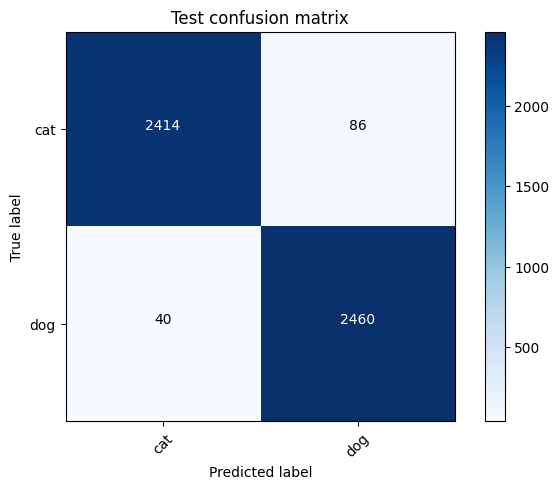

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=False`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_matrix_inc, labels, title = "Test confusion matrix")

In [ ]:
sum([conf_matrix_inc[i, i] for i in range(2)])/5000.0

0.9748